#1. Using EasyOCR to detect and recognize text
Main problem is to detect text in the image
# Run WPOD-NET for pipeline

In [ ]:
!pip install opencv-python
!pip install easyocr
!pip install tensorflow-object-detection-api

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from easyocr import Reader
import argparse
import object_detection

In [ ]:
image = cv2.imread('/content/wpod-net_2.png')
cv2_imshow(image)

In [ ]:
labels = [{'name':'licence', 'id':1}]

with open('LABELMAP.txt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [ ]:
!git clone https://github.com/nicknochnack/GenerateTFRecord.git

In [ ]:
langs = ['en']
reader = Reader(langs, gpu=True)
results = reader.readtext(image)
print(results)

#2. OpenCV approach to the problem

In [ ]:
image = cv2.imread('/content/wpod-net_1.png')
cv2_imshow(image)

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
cv2_imshow(bfilter)

In [ ]:
_, binary = cv2.threshold(bfilter, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2_imshow(binary)

In [ ]:
blur = cv2.GaussianBlur(binary, (5, 5), 0)
cv2_imshow(blur)

In [ ]:
edges = cv2.Canny(image=blur, threshold1=30, threshold2=100)
cv2_imshow(edges)

In [ ]:
# contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cv2.drawContours(gray, contours, -1, (0,255,0), 3)
# image_copy = image.copy()
# cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
solve = blur + (binary-blur)
reader = Reader(['en'], gpu=True)
results = reader.readtext(bfilter)
print(results)


#3. WPOD-NET
1. Clone the below repository and add the images to this folder

In [ ]:
!git clone https://github.com/quangnhat185/Plate_detect_and_recognize.git

Cloning into 'Plate_detect_and_recognize'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 50.59 MiB | 13.85 MiB/s, done.
Resolving deltas: 100% (69/69), done.


Change path to this directory and then import the libraries

In [ ]:
%cd /content/Plate_detect_and_recognize
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext, basename
from keras.models import model_from_json
import glob
from google.colab.patches import cv2_imshow

/content/Plate_detect_and_recognize


Loading the WPOD-NET model

In [ ]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)
        
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


Preprocess steps

In [ ]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

Preprocess steps

Found 18 images...


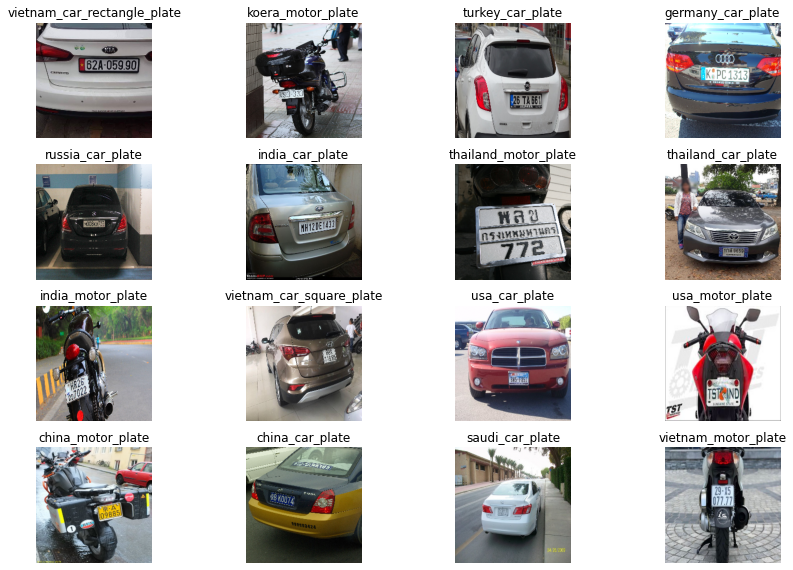

In [ ]:
# Create a list of image paths 
image_paths = glob.glob("Plate_examples/*.jpg")
print("Found %i images..."%(len(image_paths)))

# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 4
rows = 4
fig_list = []
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_paths[i]))[0]
    fig_list[-1].set_title(title)
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

In the test_image change the path to your image

Detect 2 plate(s) in usa_car_plate
Coordinate of plate(s) in image: 
 [array([[359.72167989, 496.14617107, 496.22025176, 359.79576059],
       [336.92751815, 338.23246162, 403.64109319, 402.33614972],
       [  1.        ,   1.        ,   1.        ,   1.        ]]), array([[136.00798729, 153.49169841, 152.73351176, 135.24980064],
       [378.32451232, 376.97338064, 399.49349178, 400.84462346],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


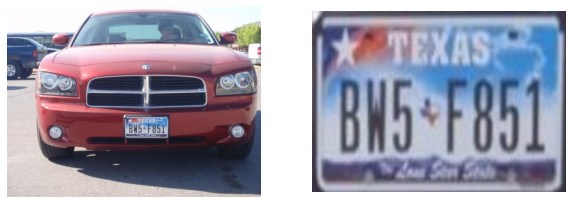

In [ ]:
def get_plate(image_path, Dmax=608, Dmin=156):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = max(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

# Obtain plate image and its coordinates from an image
test_image = '/content/Plate_detect_and_recognize/Plate_examples/usa_car_plate.jpg'
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


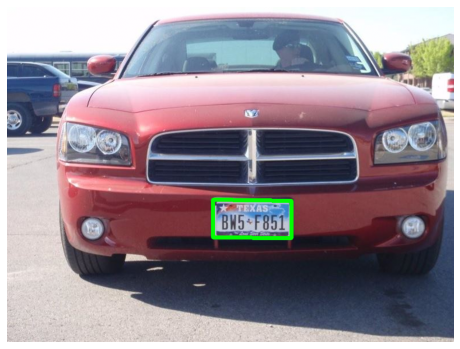

In [ ]:
def draw_box(image_path, cor, thickness=5): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

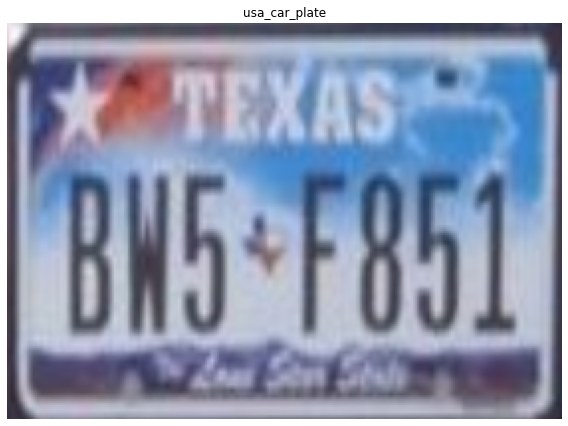

True

In [ ]:
from PIL import Image

# Viualize all obtained plate images 
fig = plt.figure(figsize=(12,6))
cols = 1
rows = 1
fig_list = []

image_path = '/content/Plate_detect_and_recognize/Plate_examples/usa_car_plate.jpg'
for i in range(cols*rows):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    title = splitext(basename(image_path))[0]
    fig_list[-1].set_title(title)
    LpImg,_ = get_plate(image_path)
    plt.axis(False)
    plt.imshow(LpImg[0])

plt.tight_layout(True)
plt.show()
cv2.imwrite('/content/Plate_detect_and_recognize/Plate_examples/china_car_plate_1.png', 255*LpImg[0])

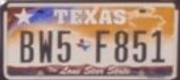

In [ ]:
image = cv2.imread('/content/Plate_detect_and_recognize/Plate_examples/china_car_plate_1.png')
image = cv2.resize(image, (180, 80))
cv2_imshow(image)

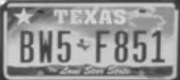

In [ ]:
gray_1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(gray_1, cv2.COLOR_RGB2GRAY)
cv2_imshow(gray)

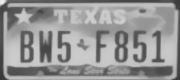

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
cv2.imwrite('/content/Plate_detect_and_recognize/Plate_examples/china_car_plate_1.png', bfilter)
cv2_imshow(bfilter)

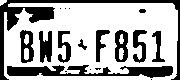

In [ ]:
_, binary = cv2.threshold(bfilter, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
cv2_imshow(binary)

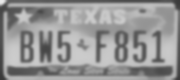

In [ ]:
blur = cv2.GaussianBlur(bfilter, (5, 5), 0)
cv2_imshow(blur)

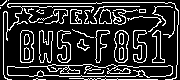

In [ ]:
edges = cv2.Canny(image=bfilter, threshold1=30, threshold2=100)
cv2_imshow(edges)

In [ ]:
#Do not run this
solve = blur + (binary-blur)
reader = Reader(['en'], gpu=True)
results = reader.readtext(bfilter)
print(results)

In [ ]:
!pip install "paddleocr>=2.0.1"
!pip install paddlepaddle

     |████████████████████████████████| 250 kB 4.0 MB/s 
     |████████████████████████████████| 948 kB 31.6 MB/s 
     |████████████████████████████████| 55.7 MB 1.3 MB/s 
     |████████████████████████████████| 123 kB 49.7 MB/s 
     |████████████████████████████████| 2.7 MB 45.3 MB/s 
     |████████████████████████████████| 57 kB 5.4 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
  Using cached pybind11-2.8.1-py2.py3-none-any.whl (208 kB)
     |████████████████████████████████| 404 kB 33.1 MB/s 
     |████████████████████████████████| 191 kB 51.6 MB/s 
     |████████████████████████████████| 127 kB 50.0 MB/s 
     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 2.1 MB 56.9 MB/s 
     |████████████████████████████████| 69 kB 7.5 MB/s 
     |████████████████████████████████| 42 kB 907 kB/s 
     |████████████████████████████████| 1.9 MB 54.2 MB/s 
     |████████████████████████████████| 596 kB 38.4 MB/s 
     |█████████████████

     |████████████████████████████████| 108.2 MB 34 kB/s 


In [ ]:
!paddleocr --image_dir /content/Plate_detect_and_recognize/Plate_examples/china_car_plate_1.png

[2021/11/29 18:55:40] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_polygon=True, 

In [ ]:
from paddleocr import PaddleOCR,draw_ocr

In [ ]:
image_path = '/content/Plate_detect_and_recognize/Plate_examples/china_car_plate_1.png'

ocr = PaddleOCR()
result = ocr.ocr(image_path, cls = True)
for line in result:
  print(line)

[2021/11/28 12:00:08] root WARNING: lang en is not support in PP-OCRv2, auto switch to version PP-OCR
[2021/11/28 12:00:08] root WARNING: lang en is not support in PP-OCRv2, auto switch to version PP-OCR
[2021/11/28 12:00:08] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
download https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_ppocr_mobile_v2.0_det_infer.tar to /root/.paddleocr/2.3.0.2/ocr/det/en/en_ppocr_mobile_v2.0_det_infer/en_ppocr_mobile_v2.0_det_infer.tar


100%|██████████| 3.16M/3.16M [00:10<00:00, 316kiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_number_mobile_v2.0_rec_infer.tar to /root/.paddleocr/2.3.0.2/ocr/rec/en/en_number_mobile_v2.0_rec_infer/en_number_mobile_v2.0_rec_infer.tar


100%|██████████| 2.70M/2.70M [00:10<00:00, 265kiB/s]


Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/2.3.0.2/ocr/det/en/en_ppocr_mobile_v2.0_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_polygon=True, e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set='totaltext', enable_mkldnn=False, gpu_mem=500, hel